In [91]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from image_similarity_measures.evaluate import evaluation
from PIL import Image
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import subprocess
import time
import seaborn as sns

In [37]:
dmd2_canny_input = 'dmd2_canny_dataset'

dmd2_canny_dataset = [file for file in os.listdir(dmd2_canny_input)]
dmd2_canny_dataset = ["./" + dmd2_canny_input + "/" + x for x in dmd2_canny_dataset]

dmd2_images_input = 'dmd2_images_dataset'

dmd2_images_dataset = [file for file in os.listdir(dmd2_images_input)]
dmd2_images_dataset = ["./" + dmd2_images_input + "/" + x for x in dmd2_images_dataset]

dmd2_orig_images_recon_input = 'dmd2_orig_images_recon'

dmd2_orig_images_recon = [file for file in os.listdir(dmd2_orig_images_recon_input)]
dmd2_orig_images_recon = ["./" + dmd2_orig_images_recon_input + "/" + x for x in dmd2_orig_images_recon]

dmd2_mod_images_recon_input = 'dmd2_mod_images_recon'

dmd2_mod_images_recon = [file for file in os.listdir(dmd2_mod_images_recon_input)]
dmd2_mod_images_recon = ["./" + dmd2_mod_images_recon_input + "/" + x for x in dmd2_mod_images_recon]

In [19]:
vgg16 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

# Freezing the layers
for model_layer in vgg16.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    """
    Load and preprocess an image in grayscale for the VGG16 model, 
    ensuring it retains 3 channels (replicating the grayscale values across them).
    """
    # Load the image in grayscale mode
    img = image.load_img(image_path, target_size=(224, 224), color_mode='grayscale')
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Manually replicate the grayscale channel to make it 3 channels
    img_array_3channel = np.repeat(img_array, 3, axis=-1)
    
    # Expand dimensions to match the input shape expected by the model
    img_array_expanded = np.expand_dims(img_array_3channel, axis=0)
    
    # Preprocess the image (using VGG16 preprocess_input)
    return preprocess_input(img_array_expanded)

def get_image_embeddings(img_array):
    """
    Get image embeddings using the VGG16 model.
    """
    return vgg16.predict(img_array)

def get_similarity_score(first_image_path, second_image_path):
    """
    Compute the similarity score between two images.
    """
    first_image_array = load_and_preprocess_image(first_image_path)
    second_image_array = load_and_preprocess_image(second_image_path)
    first_image_embedding = get_image_embeddings(first_image_array)
    second_image_embedding = get_image_embeddings(second_image_array)
    return cosine_similarity(first_image_embedding, second_image_embedding)[0][0]

In [20]:
def normalized_hausdorff_distance(img1, img2):
    # Find Canny edges for both images
    edges1 = cv.Canny(img1, 100, 200)
    edges2 = cv.Canny(img2, 100, 200)

    # Get the coordinates of edge points in both images
    points1 = np.column_stack(np.where(edges1 > 0))
    points2 = np.column_stack(np.where(edges2 > 0))

    # Compute directed Hausdorff distances
    d_forward = directed_hausdorff(points1, points2)[0]
    d_reverse = directed_hausdorff(points2, points1)[0]

    # Hausdorff distance is the max of the two directed distances
    hausdorff_dist = max(d_forward, d_reverse)

    # Calculate the diagonal of the image (the longest possible distance)
    height, width = img1.shape
    diagonal = np.sqrt(width**2 + height**2)

    # Normalize the Hausdorff distance by the diagonal
    normalized_dist = hausdorff_dist / diagonal
    return normalized_dist

In [21]:
def contraharmonic_mean(num1, num2):
    return (num1**2 + num2**2) / (num1 + num2)

In [22]:
contraharmonic_scores = []

for i in range(len(dmd2_images_dataset)):
    similarity_score_orig = get_similarity_score(dmd2_images_dataset[i], dmd2_orig_images_recon[i])
    img1 = cv.imread(dmd2_images_dataset[i], 0)
    img2 = cv.imread(dmd2_orig_images_recon[i], 0)
    hausdorff_score_orig = normalized_hausdorff_distance(img1, img2)
    complement_hausdorff_score_orig = 1 - hausdorff_score_orig
    contraharmonic_score_orig = contraharmonic_mean(similarity_score_orig, complement_hausdorff_score_orig)

    similarity_score_mod = get_similarity_score(dmd2_images_dataset[i], dmd2_mod_images_recon[i])
    img1 = cv.imread(dmd2_images_dataset[i], 0)
    img2 = cv.imread(dmd2_mod_images_recon[i], 0)
    hausdorff_score_mod = normalized_hausdorff_distance(img1, img2)
    complement_hausdorff_score_mod = 1 - hausdorff_score_mod
    contraharmonic_score_mod = contraharmonic_mean(similarity_score_mod, complement_hausdorff_score_mod)

    contraharmonic_scores.append(max(contraharmonic_score_orig, contraharmonic_score_mod))

1/1 [==============================] - 0s 120ms/step


In [38]:
dataset_image_sizes = [os.path.getsize(path) for path in dmd2_images_dataset]

In [29]:
conditioning_input_sizes = []

for i in range(len(dmd2_images_dataset)):
    result = subprocess.run(['.\compression\jbig2', '-s', '-p', dmd2_canny_dataset[i]], text=True, capture_output=True)
    time.sleep(0.1)
    conditioning_input_sizes.append(os.path.getsize('./output.0000') + os.path.getsize('./output.sym'))

In [39]:
bandwidth_savings = []

for i in range(len(dmd2_images_dataset)):
    saving = (dataset_image_sizes[i] - conditioning_input_sizes[i]) / dataset_image_sizes[i]
    saving = saving * 100
    bandwidth_savings.append(saving)

In [43]:
with open('dmd2_orig_times.txt', 'r') as file:
    # Read each line, strip newline characters, and store it in a list
    dmd2_orig_times = [float(line.strip()) for line in file.readlines()]

with open('dmd2_mod_times.txt', 'r') as file:
    # Read each line, strip newline characters, and store it in a list
    dmd2_mod_times = [float(line.strip()) for line in file.readlines()]

In [47]:
generation_times = [min(dmd2_orig_times[i], dmd2_mod_times[i]) for i in range(len(dmd2_images_dataset))]

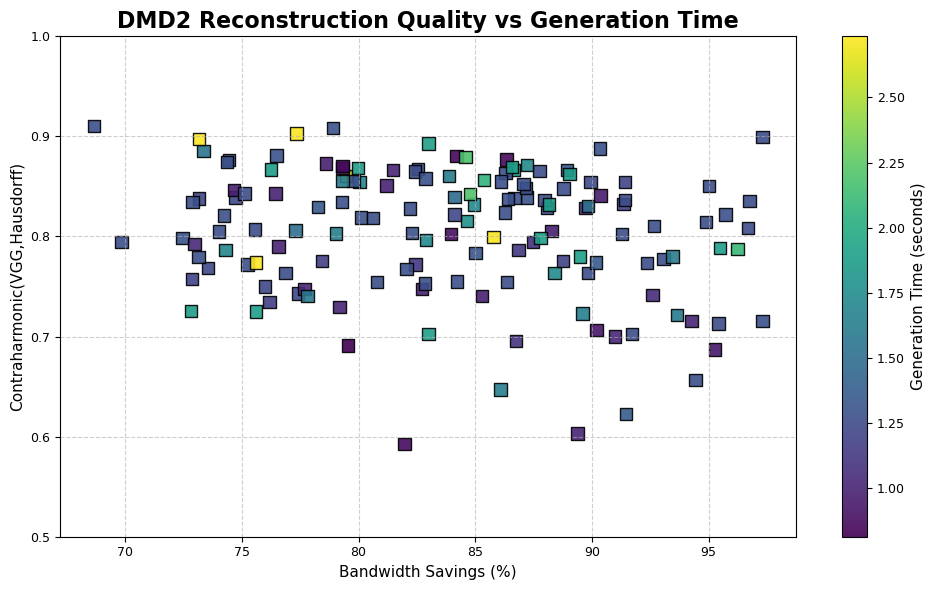

In [90]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(bandwidth_savings, contraharmonic_scores, 
                      c=generation_times, cmap='viridis', s=80, alpha=0.9, edgecolor='k', marker=',')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Generation Time (seconds)', fontsize=11)
cbar.ax.tick_params(labelsize=9)

# Add labels and title
plt.xlabel('Bandwidth Savings (%)', fontsize=11)
plt.ylabel('Contraharmonic(VGG,Hausdorff)', fontsize=11)
plt.title('DMD2 Reconstruction Quality vs Generation Time', fontsize=16, fontweight='bold')

# Add grid and polish the layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Set axis limits
plt.ylim(0.5, 1)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

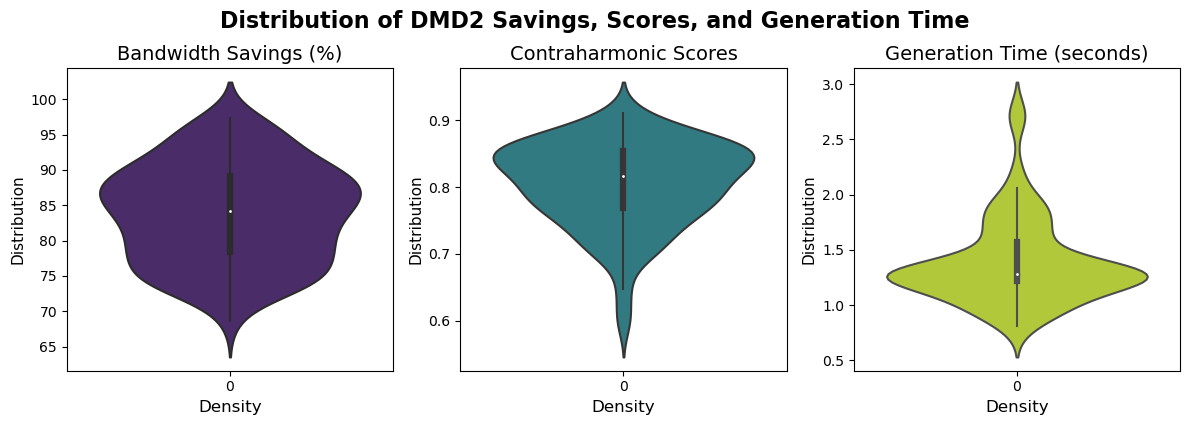

In [101]:
# Create a figure with smaller subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Define color palette
viridis_colors = sns.color_palette("viridis", 10)

# Plotting each feature with viridis color scheme
sns.violinplot(data=bandwidth_savings, ax=axes[0], inner='box', color=viridis_colors[0])
sns.violinplot(data=contraharmonic_scores, ax=axes[1], inner='box', color=viridis_colors[4])
sns.violinplot(data=generation_times, ax=axes[2], inner='box', color=viridis_colors[9])

# Setting titles and labels
axes[0].set_title('Bandwidth Savings (%)', fontsize=14)
axes[0].set_ylabel('Distribution', fontsize=11)

axes[1].set_title('Contraharmonic Scores', fontsize=14)
axes[1].set_ylabel('Distribution', fontsize=11)

axes[2].set_title('Generation Time (seconds)', fontsize=14)
axes[2].set_ylabel('Distribution', fontsize=11)

# Adding x-labels
for ax in axes:
    ax.set_xlabel('Density', fontsize=12)

# Layout adjustment
plt.tight_layout()
plt.suptitle('Distribution of DMD2 Savings, Scores, and Generation Time', fontsize=16, y=1.05, fontweight='bold')

# Show the plot
plt.show()